# Load Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import time
import pickle
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.models import load_model

path_main_folder = '/home/antorosi/Documents/Classification/'
path_prediction_folder = '/home/antorosi/Documents/Prediction/'
path_autoencoder_folder = '/home/antorosi/Documents/AutoEncoder/'

sys.path.append(path_main_folder)
sys.path.append(path_prediction_folder)
sys.path.append(path_autoencoder_folder)

# Main methods
from helpers.visualization import pyplot_latent_space_atypial_events, pyplot_latent_space_selected_atypial_events

# Predictive AED methods
from conso.load_shape_data import load_data_conso, get_uniformed_data_conso, change_granularity, get_x_y_prediction_conso, get_train_test_sets, normalized_dataset, select_variables, add_atypical_events_to_dict_data_conso
from models.feedforward_NN import FeedForward
from aed.detection import get_next_hd_events, sort_atypical_events, get_residuals, get_atypical_score, get_atypical_ds, prediction_conso_plot, aed_conso_plot
from aed.atypical_event import AtypicalEvent, AtypicalEventsList, get_atypical_events_list, apply_ael_to_df, get_confusion_matrix
from aed.verification import *
from aed.multi_period import get_prediction_results, get_aed_results, get_complete_df

# AE methods
from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE
from conso.load_shape_data import *  
from conso.conso_helpers import *

/local/home/antorosi/PycharmProjects/KERAS-TS-VENV/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load aed predictive results 

In [2]:
path_out = os.path.join(path_main_folder, 'out')

### Get original data 

In [3]:
# Load
path_data = os.path.join(path_prediction_folder, 'data')
dict_data_conso = load_data_conso(path_data)

# Uniformization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

# Granularity from 15 min to 1H
data_conso_df = change_granularity(data_conso_df, granularity="1H")

### Multi period prediction and aed results

In [4]:
# model paths
path_models_folder = os.path.join(path_prediction_folder, 'out', 'cv_model_1.2')
name_dict_dataset = 'dict_datasets.pickle'
name_model = 'FFNN'
type_model = 'keras'

In [5]:
# get prediction results
mode = 4
prediction_results = get_prediction_results(path_models_folder, name_dict_dataset, mode=mode, type_model=type_model)

In [6]:
# get atypical events info
threshold = 0.98
aed_results, ael_full_model = get_aed_results(prediction_results, threshold)

In [7]:
# getting complete dataframe
atypical_full_df, prediction_full_df = get_complete_df(prediction_results, aed_results)

In [8]:
# Loading list
path_data = os.path.join("/local/home/antorosi/Documents/Prediction/data")
with open(os.path.join(path_data, 'ae_reference_list_wwe_2013-2017' + '.pickle'), 'rb') as f:
    ael_reference= pickle.load(f)

In [9]:
# get infos about top atypical days
pd.options.display.max_rows = 200
atypical_daily_df = sort_atypical_events(atypical_full_df, ael_reference)

In [10]:
atypical_daily_df = atypical_daily_df.sort_values(by='ds')
atypical_daily_df = atypical_daily_df.reset_index(drop=True)

# Load AutoEncoder Embedding 

In [11]:
# model paths
path_model_folder = os.path.join(path_autoencoder_folder, 'out', 'cvae_classification')
name_model = 'CVAE'

### Load data

In [12]:
name_dataset = 'dataset.pickle'
with open(os.path.join(path_model_folder, name_dataset), 'rb') as f:
    dataset = pickle.load(f)

In [13]:
# Load Holiday day information
path_data = os.path.join(path_autoencoder_folder, 'data')

holiday_days_csv = os.path.join(path_data, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

### Load model

In [14]:
# model characteristics
cond_dim = dataset['train']['x'][1].shape[1]
e_dims=[48,24,12]
d_dims=[12,24,48]
z_dim= 2
beta = 0.6

In [15]:
name_type_cond = 'm-wd'

In [16]:
model = CVAE(cond_dim=cond_dim, e_dims=e_dims, d_dims=d_dims, 
             z_dim=z_dim, beta=beta, name=name_model, output=path_model_folder, verbose=False)
model.load_model(os.path.join(path_model_folder,'models'))

# Matching data

In [17]:
prediction_ds = atypical_daily_df['ds']
autoencoder_ds = dataset['train']['ds']

In [18]:
mask = autoencoder_ds.isin(prediction_ds)

In [19]:
dataset['train']['x'][0] = dataset['train']['x'][0][mask]
dataset['train']['x'][1] = dataset['train']['x'][1][mask]
dataset['train']['y'] = dataset['train']['y'][mask]
dataset['train']['ds'] = dataset['train']['ds'][mask].reset_index(drop=True)

In [20]:
name_set_plot = 'train'
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

# Analysis

In [21]:
# get embedding 
x_encoded = model.encoder.predict(dataset[name_set_plot]['x'])[0]

In [22]:
version = 'v0'

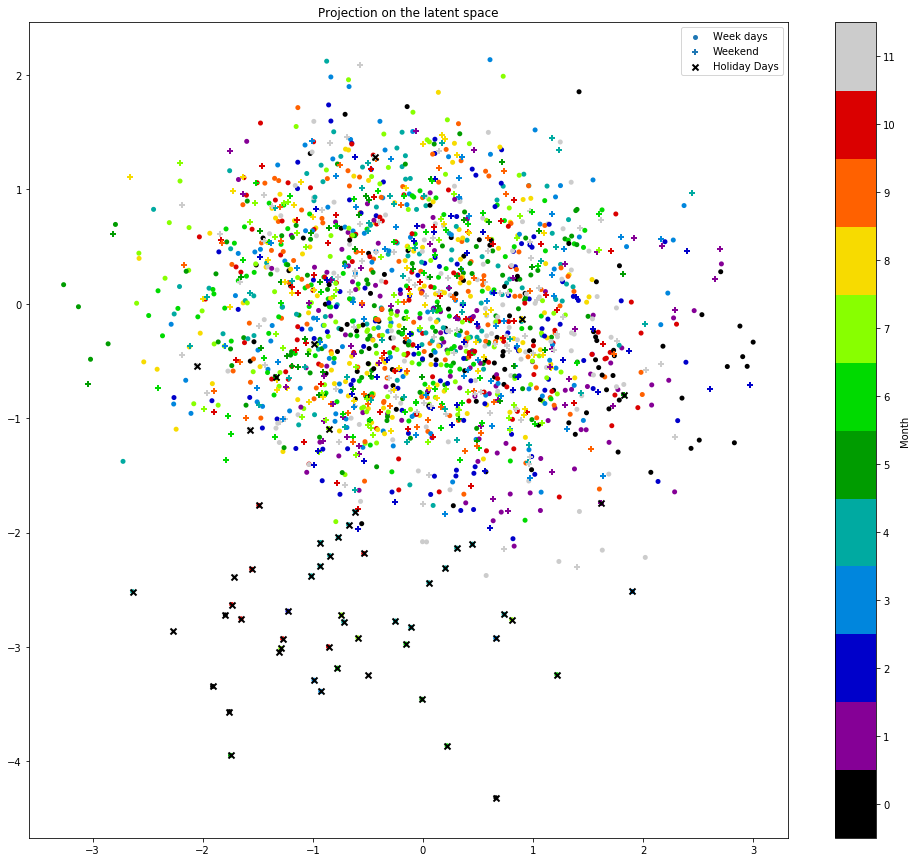

In [23]:
# Latent space projection
name_plot = 'z{}_beta-{}_set-{}_cond-{}{}'.format(str(z_dim),str(beta), name_set_plot,str(name_type_cond),version)
plot_latent_space_projection(x_proj=x_encoded, calendar_info=calendar_info,
                             path_folder_out=os.path.join(path_out,'figures'), name=name_plot, 
                             pyplot=True, plotly = False)

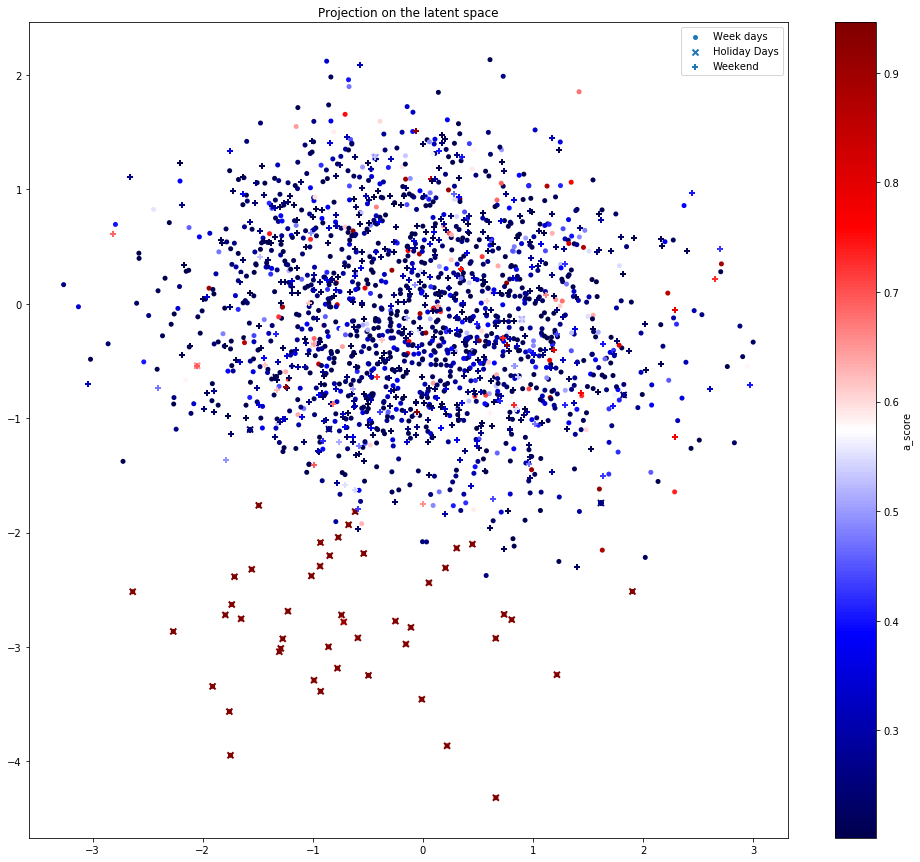

In [24]:
# Atyppical event representation

name_plot = 'ae_z{}_beta-{}_set-{}_cond-{}{}'.format(str(z_dim),str(beta), name_set_plot,str(name_type_cond),version)
pyplot_latent_space_atypial_events(x_proj=x_encoded, calendar_info=calendar_info,
                                   a_score = atypical_daily_df['a_score'],
                                   path_folder_out=os.path.join(path_out,'figures'), name=name_plot)

0.6174303496273847


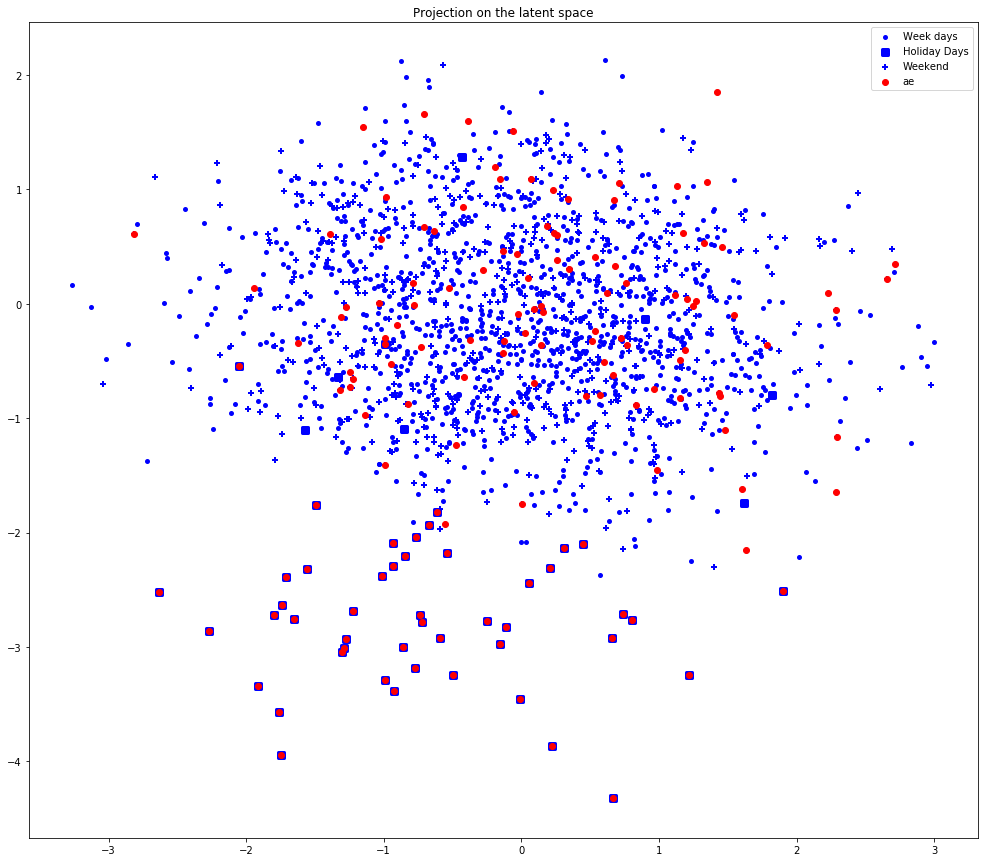

In [27]:
name_plot = 'ae_z{}_beta-{}_set-{}_cond-{}{}'.format(str(z_dim),str(beta), name_set_plot,str(name_type_cond),version)
nb_events = 150


pyplot_latent_space_selected_atypial_events(x_proj=x_encoded, calendar_info=calendar_info,
                                   a_score = atypical_daily_df['a_score'], nb_events=nb_events,
                                   path_folder_out=os.path.join(path_out,'figures'), name=name_plot)

In [27]:
a_score = atypical_daily_df['a_score']

In [28]:
np.array(a_score)

array([1.        , 0.65956747, 0.31600051, ..., 0.25487526, 0.21084314,
       0.31749146])

In [36]:
test = a_score.sort_values(ascending=False).reset_index(drop=True)[100]

In [29]:
a_score.sort_values(ascending=False)

723     1.000000
0       1.000000
120     1.000000
1819    1.000000
1410    1.000000
1095    1.000000
358     1.000000
485     1.000000
850     1.000000
1088    1.000000
1581    1.000000
524     1.000000
924     1.000000
1044    1.000000
1400    0.999999
1182    0.999999
1567    0.999999
1765    0.999999
90      0.999998
475     0.999997
559     0.999997
679     0.999997
314     0.999996
304     0.999996
730     0.999995
1655    0.999994
1616    0.999994
1322    0.999993
1290    0.999993
365     0.999992
825     0.999969
857     0.999955
874     0.999954
1220    0.999938
863     0.999928
513     0.999916
1687    0.999803
1588    0.999791
492     0.999617
1231    0.999525
139     0.999057
591     0.998173
1605    0.996938
226     0.996836
127     0.987541
121     0.983500
119     0.982028
484     0.976285
1219    0.974995
1764    0.966929
856     0.966829
1409    0.965724
1462    0.964269
849     0.956562
491     0.953090
128     0.948941
1818    0.945898
1654    0.945751
1604    0.9409

In [37]:
test

0.7459310072183739